In [1]:
# Core libs
import pandas as pd
import numpy as np
import importlib

# Graphic libs
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
pio.renderers.default = "browser"

# sklearn 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_absolute_percentage_error as LMAPE

# IA + blockchain = profit
import tensorflow as tf
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Lambda, Dropout, BatchNormalization, Activation, Dense, LeakyReLU, Add
from keras.layers.merging import Add, Concatenate
from keras.utils import plot_model, to_categorical

2022-12-06 18:40:54.064734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 18:40:54.953827: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-06 18:40:56.173462: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-06 18:40:56.173586: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [14]:
SIMPLE_COLUMNS = [
    'Fecha',
    'TipoDeVia',
    'Piso',
    'Departamento',
    'Provincia',
    'Distrito',
    'Estacionamiento',
    'Depositos',
    'Lat',
    'Lon',
    'Categoria',
    'Posicion',
    'Frentes',
    'Edad',
    'Elevador',
    'Conservacion',
    'Metodo',
    'AreaTerreno',
    'AreaConstruccion',
    'Valorcomercial'
]

NUMERIC_COLS = [
    'Fecha entrega del Informe',
    'Tipo de vía','Latitud (Decimal)',
    'Longitud (Decimal)',
    'Número de frentes',
    'Edad',
    'Elevador',
    'Área Terreno',
    'Área Construcción',
    'Valor comercial (USD)',
    'ranva'
]

In [134]:
def data_sanitize(raw_data, train = False, region = None):

    if region is not None:
        ordinal_data = raw_data[raw_data[region[0]] == region[1]].copy()
    else:
        ordinal_data = raw_data.copy()

    for column in raw_data[:-2]:
        dist_encod = OrdinalEncoder()

        if column in NUMERIC_COLS:
            continue

        enc = dist_encod.fit_transform(ordinal_data[[column,'ranva']].to_numpy(dtype = str))
        ordinal_data[column] = enc.T[0]

    ordinal_data = ordinal_data.drop('ranva', axis = 1)

    ordinal_data = ordinal_data.applymap(lambda x : float(x.replace(',','')) if isinstance(x,str) else x)
    ordinal_data.columns = SIMPLE_COLUMNS
    scale_data = ordinal_data.applymap(lambda x : np.cbrt(x))

    if train:
        ground_truth = ordinal_data['Valorcomercial'].to_numpy()
        return scale_data, ground_truth
    
    return scale_data

def pca_plot_plotly(data, hue, n_components = -1, out = []):
    if len(out) != 0:
        data = data.drop(out, axis = 1)

    plot_pca = PCA()
    plot_pca.fit(data)
    X = data.to_numpy().T

    if n_components != -1: 
        components = (plot_pca.components_[:n_components,:]@X).T
    else: 
        components = (plot_pca.components_@X).T
    
    components_df = pd.DataFrame(components, columns=['PC'+str(i+1)+' ({:.1f})%'.format(plot_pca.explained_variance_ratio_[i]*100) for i in range(components.shape[1])])

    fig = px.scatter_matrix(components_df,
        dimensions=['PC'+str(i+1)+' ({:.1f})%'.format(plot_pca.explained_variance_ratio_[i]*100) for i in range(components.shape[1])],
        color=hue,
        title="PCA Pairs plot",
        labels=components_df.columns)
    fig.update_traces(diagonal_visible=False)
    fig.update_traces(marker_size=1)

    fig.update_layout(font=dict(size=10))

    fig.update_layout({"xaxis"+str(i+1): dict(showticklabels = False) for i in range(components.shape[1])})
    fig.update_layout({"yaxis"+str(i+1): dict(showticklabels = False, title='PC'+str(i+1)) for i in range(components.shape[1])})

    fig.update_layout(margin={"r":150,"t":20,"l":150,"b":20})
    fig.show()

def data_plot_plotly(data, hue, out = []):
    plot_vars = []
    for var in data.columns:
        if var not in out:
            plot_vars.append(var)

    fig = px.scatter_matrix(data,
                            dimensions=plot_vars,
                            title="Scatter matrix of data set",
                            color=hue,
                            labels=plot_vars)
    fig.update_traces(diagonal_visible=False)
    fig.update_traces(marker_size=1)

    fig.update_layout(font=dict(size=10))

    try:
        fig.update_layout({"xaxis"+str(i+1): dict(showticklabels = False, title=plot_vars[i][:3].upper()) for i in range(len(plot_vars))})
        fig.update_layout({"yaxis"+str(i+1): dict(showticklabels = False, title=plot_vars[i][:3].upper()) for i in range(len(plot_vars))})
    except:
        pass

    fig.update_layout(margin={"r":150,"t":20,"l":150,"b":20})
    fig.show()


In [4]:
raw_data_master = pd.read_excel('../data/xlsx/ord80p.xlsx', header = [0]).applymap(lambda x : (x - pd.Timestamp("1900-01-01 00:00:00")).days + 2 if isinstance(x,pd.Timestamp) else x).fillna(-1)
raw_test_master = pd.read_excel('../data/xlsx/ord20p.xlsx', header = [0]).applymap(lambda x : (x - pd.Timestamp("1900-01-01 00:00:00")).days + 2 if isinstance(x,pd.Timestamp) else x).fillna(-1)

In [85]:
trainer_data, train_gt = data_sanitize(raw_data_master, True, ('Provincia', 'Lima'))
tester_data, test_gt = data_sanitize(raw_test_master, True, ('Provincia', 'Lima'))

In [37]:
to_out = ['Departamento','Piso','Posicion','Provincia','Frentes','Elevador','Lat', 'Lon']

In [35]:
data_plot_plotly(trainer_data, hue = trainer_data['Valorcomercial'], out = to_out)

In [48]:
pca_plot_plotly(trainer_data, hue = trainer_data['TipoDeVia'], out = to_out)

/home/ric/Documents/Code/hackathonBBVA/venv/lib/python3.10/site-packages/plotly/express/_core.py:137: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [55]:
to_out = ['Departamento','Piso','Posicion','Provincia','Frentes','Elevador','Lat', 'Lon']
pca_plot_plotly(trainer_data, hue = trainer_data['AreaTerreno'], out = to_out)

/home/ric/Documents/Code/hackathonBBVA/venv/lib/python3.10/site-packages/plotly/express/_core.py:137: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [63]:
UNINTERESTING = [
    'TipoDeVia',
    'Piso',
    'Departamento',
    'Provincia',
    'Depositos',
    'Lat',
    'Lon',
    'Categoria',
    'Posicion',
    'Frentes',
    'Elevador',
    'Metodo', 
    'AreaTerreno'
]

pca_plot_plotly(trainer_data, hue = trainer_data['AreaConstruccion'], out = UNINTERESTING)

/home/ric/Documents/Code/hackathonBBVA/venv/lib/python3.10/site-packages/plotly/express/_core.py:137: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [89]:
UNINTERESTING_A = [
    'TipoDeVia',
    'Piso',
    'Departamento',
    'Provincia',
    'Depositos',
    'Lat',
    'Lon',
    'Categoria',
    'Posicion',
    'Frentes',
    'Elevador',
    'Metodo', 
    'AreaTerreno'
]

UNINTERESTING_B = [
    'TipoDeVia',
    'Piso',
    'Departamento',
    'Provincia',
    'Depositos',
    'Lat',
    'Lon',
    'Categoria',
    'Posicion',
    'Frentes',
    'Elevador',
    'Metodo', 
    'AreaConstruccion'
]

pca_train = trainer_data[trainer_data['AreaConstruccion'] > 0].drop(UNINTERESTING_A, axis = 1)
pca_test = tester_data[tester_data['AreaConstruccion'] > 0].drop(UNINTERESTING_A, axis = 1)

#pca_train = trainer_data[trainer_data['AreaConstruccion'] <= 0].drop(UNINTERESTING_B, axis = 1)
#pca_test = tester_data[tester_data['AreaConstruccion'] <= 0].drop(UNINTERESTING_B, axis = 1)

#pca_plot_plotly(pca_train, hue = pca_train['Valorcomercial'])
#pca_plot_plotly(pca_test, hue = pca_test['Valorcomercial'])
#data_plot_plotly(pca_train, hue = pca_train['Valorcomercial'])
#data_plot_plotly(pca_test, hue = pca_test['Valorcomercial'])

In [199]:
data_dim = pca_train.shape[1]

Xin = Input(shape=(data_dim,),name='In')

#Encoder 
X = Dense(data_dim)(Xin)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)

#Code
code_rep = Dense(5,activation='tanh')(X)
CODE = Model(inputs = Xin, outputs = [code_rep], name = "Encode")

#Decoder
X = Dense(data_dim)(code_rep)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
Decoded = LeakyReLU()(X)

AUTOENCODER = Model(inputs = Xin, outputs = [Decoded], name = 'Auto_encoder')

In [200]:
epochs     = 1500        # número de epocas
batch_size = 1000         # tamaño del lote
alpha      = 0.001     # razon de aprendizaje
decay      = 0.0001    # decaimiento de alpha

AUTOENCODER.compile(optimizer = optimizers.Adam(learning_rate=alpha, decay=decay),
                      loss      = 'mae',
                      metrics   = ['accuracy'])

#Jengi_train.summary()

history = AUTOENCODER.fit(x                = pca_train,
                          y                = pca_train,
                          batch_size       = batch_size,
                          epochs           = epochs,
                          validation_split = 0.2,
                          verbose          = 1)

Epoch 1/1500
21/21 [==============================] - 1s 18ms/step - loss: 15.6067 - accuracy: 0.0000e+00 - val_loss: 15.6017 - val_accuracy: 0.0000e+00
Epoch 2/1500
21/21 [==============================] - 0s 7ms/step - loss: 15.4028 - accuracy: 0.0000e+00 - val_loss: 15.3002 - val_accuracy: 0.0000e+00
Epoch 3/1500
21/21 [==============================] - 0s 9ms/step - loss: 15.0514 - accuracy: 0.0000e+00 - val_loss: 14.8542 - val_accuracy: 0.0000e+00
Epoch 4/1500
21/21 [==============================] - 0s 7ms/step - loss: 14.3387 - accuracy: 0.0118 - val_loss: 13.8688 - val_accuracy: 0.0321
Epoch 5/1500
21/21 [==============================] - 0s 8ms/step - loss: 13.3958 - accuracy: 0.0339 - val_loss: 12.8380 - val_accuracy: 0.0321
Epoch 6/1500
21/21 [==============================] - 0s 8ms/step - loss: 11.6260 - accuracy: 0.0339 - val_loss: 9.6528 - val_accuracy: 0.0321
Epoch 7/1500
21/21 [==============================] - 0s 8ms/step - loss: 8.4160 - accuracy: 0.0339 - val_loss: 

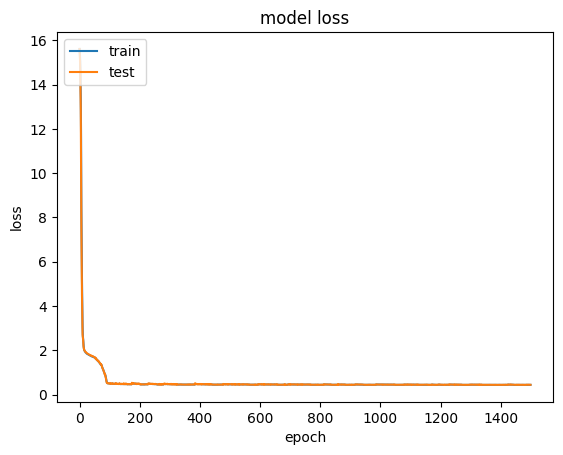

In [201]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [202]:
res = CODE.predict(pca_train)
res_df = pd.DataFrame(res)
data_plot_plotly(res_df, hue = pca_train['Valorcomercial'])

813/813 [==============================] - 1s 1ms/step


In [204]:
price_encoded = (pca_test['Valorcomercial'].to_numpy())**3

res = AUTOENCODER.predict(pca_test)
price_decoded = (res.T[-1])**3

203/203 [==============================] - 1s 2ms/step


In [205]:
print(LMAPE(price_encoded, price_decoded))
print(price_encoded[:10])
print(price_decoded[:10])

0.004905509523079617
[ 247328.  165675. 1542273.   54705.   64184.  170437.  652150.  146460.
   89383.  143374.]
[ 246879.73   165941.02  1499461.2     55063.137   64492.805  170917.39
  650554.4    146178.92    89835.25   143048.4  ]


In [189]:
X_train = np.concatenate([pca_train.drop('Valorcomercial', axis = 1), np.zeros((pca_train.shape[0],1))], axis = 1)
Y_train = CODE.predict(pca_train)

813/813 [==============================] - 1s 1ms/step


In [190]:
Xin = Input(shape=(X_train.shape[1],),name='In')
X = Dense(10)(Xin)
X = LeakyReLU()(X)
X = Dense(10)(X)
X = LeakyReLU()(X)
X = Dense(10)(X)
X = LeakyReLU()(X)
X = Dense(10)(X)
X = LeakyReLU()(X)
X = Dense(10)(X)
X = LeakyReLU()(X)
X = Dense(10)(X)
X = LeakyReLU()(X)
X = Dense(X_train.shape[1])(X)
completion = LeakyReLU()(X)
CBRT_predictor = Model(inputs = Xin, outputs = [completion], name = "Predictor")

in_completed = Add(name = 'completion')([Xin,completion])
CODE.trainable = False
Yout = CODE(in_completed)

CODE_Trainer = Model(inputs = Xin, outputs = [Yout], name = 'encode_train')

In [191]:
epochs     = 1500        # número de epocas
batch_size = 1000         # tamaño del lote
alpha      = 0.001     # razon de aprendizaje
decay      = 0.0001    # decaimiento de alpha

CODE_Trainer.compile(optimizer = optimizers.Adam(learning_rate=alpha, decay=decay),
                    loss      = 'mse',
                    metrics   = ['accuracy'])

#Jengi_train.summary()

history = CODE_Trainer.fit(x                = X_train,
                           y                = Y_train,
                           batch_size       = batch_size,
                           epochs           = epochs,
                           validation_split = 0.2,
                           verbose          = 1)

Epoch 1/1500
21/21 [==============================] - 1s 15ms/step - loss: 0.0503 - accuracy: 0.3969 - val_loss: 0.0435 - val_accuracy: 0.9967
Epoch 2/1500
21/21 [==============================] - 0s 7ms/step - loss: 0.0352 - accuracy: 0.9998 - val_loss: 0.0311 - val_accuracy: 1.0000
Epoch 3/1500
21/21 [==============================] - 0s 7ms/step - loss: 0.0279 - accuracy: 1.0000 - val_loss: 0.0250 - val_accuracy: 1.0000
Epoch 4/1500
21/21 [==============================] - 0s 7ms/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.0167 - val_accuracy: 1.0000
Epoch 5/1500
21/21 [==============================] - 0s 6ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 6/1500
21/21 [==============================] - 0s 6ms/step - loss: 0.0132 - accuracy: 1.0000 - val_loss: 0.0134 - val_accuracy: 1.0000
Epoch 7/1500
21/21 [==============================] - 0s 6ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch

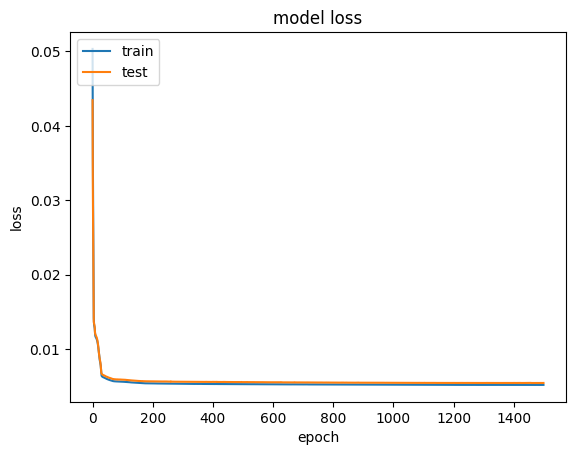

In [192]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [193]:
X_test = np.concatenate([pca_test.drop('Valorcomercial', axis = 1), np.zeros((pca_test.shape[0],1))], axis = 1)
Y_test = (pca_test['Valorcomercial'].to_numpy())**3

res = CBRT_predictor.predict(X_test)
Y_hat = (res.T[-1])**3

203/203 [==============================] - 0s 1ms/step


In [194]:
print(LMAPE(Y_test, Y_hat))
print(Y_test[:10])
print(Y_hat[:10])

1.3411473851592668
[ 247328.  165675. 1542273.   54705.   64184.  170437.  652150.  146460.
   89383.  143374.]
[  -41234.78    -34715.38  -2289987.8      -7082.611   -12340.849
   -32454.555  -151736.05    -23866.098   -27732.348   -21277.748]


In [195]:
res_df = pd.DataFrame(res, columns = pca_test.columns)
data_plot_plotly(res_df, hue = np.cbrt(Y_hat))

In [206]:
Xp_test = np.concatenate([pca_test.drop('Valorcomercial', axis = 1), np.zeros((pca_test.shape[0],1))], axis = 1)

resp = AUTOENCODER.predict(Xp_test)
Yp_hat = (resp.T[-1])**3

203/203 [==============================] - 1s 2ms/step


In [207]:
print(LMAPE(Y_test, Yp_hat))
print(Y_test[:10])
print(Yp_hat[:10])

0.9980834101648278
[ 247328.  165675. 1542273.   54705.   64184.  170437.  652150.  146460.
   89383.  143374.]
[278.64114 297.60294 736.7074  223.95688 237.76901 286.6065  258.73334
 218.55609 291.8594  246.15894]


In [213]:
resp_df = pd.DataFrame(resp**3, columns = pca_test.columns)
data_plot_plotly(resp_df, hue = np.cbrt(Yp_hat))

In [212]:
Xp_df = pd.DataFrame(Xp_test, columns = pca_test.columns)
data_plot_plotly(Xp_df, hue = np.cbrt(Yp_hat))